In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import gridspec
import argparse
import h5py as h5
import os
import tensorflow as tf
import horovod.tensorflow.keras as hvd
import preprocessing
import utils
from toy_parallel import FFJORD, BACKBONE_ODE, make_bijector_kwargs, load_model

In [2]:
def DataLoader_no_scale(file_name, nevts):
    '''
    Inputs:
    - name of the file to load
    - number of events to use
    Outputs:
    - Generated particle energy (value to condition the flow) (nevts,1)
    - Energy deposition in each layer (nevts,3)
    - Normalized energy deposition per voxel (nevts,504)
    '''
    with h5.File(file_name,"r") as h5f:
        e = h5f['energy'][:int(nevts)].astype(np.float32)
        layer0= h5f['layer_0'][:int(nevts)].astype(np.float32)
        layer1= h5f['layer_1'][:int(nevts)].astype(np.float32)
        layer2= h5f['layer_2'][:int(nevts)].astype(np.float32)

    def preprocessing(data):
        ''' 
        Inputs: Energy depositions in a layer
        Outputs: Total energy of the layer and normalized energy deposition
        '''
        x = data.shape[1]
        y = data.shape[2]
        data_flat = np.reshape(data,[-1,x*y])
        #uncomment below to add noise like caloflows does
        #data_flat +=np.random.uniform(0,1e-3,size=data_flat.shape)
        energy_layer = np.sum(data_flat,-1).reshape(-1,1)
        #Some particle showers have no energy deposition at the last layer
        data_flat = np.ma.divide(data_flat,energy_layer).filled(0)
        return energy_layer,data_flat


    flat_energy , flat_shower = preprocessing(np.nan_to_num(layer0))    
    for il, layer in enumerate([layer1,layer2]):
        energy ,shower = preprocessing(np.nan_to_num(layer))
        flat_energy = np.concatenate((flat_energy,energy),-1)
        flat_shower = np.concatenate((flat_shower,shower),-1)
        
    return e,flat_energy,flat_shower

In [3]:
hvd.init()
#utils.SetStyle()
file_path = "/global/cfs/cdirs/m3246/haoxing_du/sampling_gamma_corr.hdf5"
plot_folder = "../plots"
nevts = 50000
config = "config_calorimeter.json"

dataset_config = preprocessing.LoadJson(config)

In [4]:
# Load Geant data from hdf5 file without applying preprocessing for training
# gen_etot (GeV)        : shape (nevts, 1)
# gen_elayers (GeV)     : shape (nevts, 3)
# gen_voxels (fraction) : shape (nevts, 504)

gen_etot, gen_elayers, gen_voxels = DataLoader_no_scale(file_path, nevts)
gen_elayers /= 1000
gen_log_e = np.log10(gen_etot/10)
for i,event in enumerate(gen_voxels):
    gen_voxels[i][:288] = gen_elayers[i][0] * gen_voxels[i][:288]
    gen_voxels[i][288:432] = gen_elayers[i][1] * gen_voxels[i][288:432]
    gen_voxels[i][432:] = gen_elayers[i][2] * gen_voxels[i][432:]

In [23]:
with open("../samples/sample0.npy", "rb") as f:
    sample0 = np.load(f)
with open("../samples/sample1.npy", "rb") as f:
    sample1 = np.load(f)
with open("../samples/sample2.npy", "rb") as f:
    sample2 = np.load(f)
with open("../samples/sample3.npy", "rb") as f:
    sample3 = np.load(f)
flow_voxels = np.concatenate([sample0, sample1, sample2, sample3])
flow_voxels[flow_voxels<1e-4]=0

In [24]:
flow_layer0, flow_layer1, flow_layer2 = [], [], []
for event in flow_voxels:
    flow_layer0.append(np.sum(event[:288]))
    flow_layer1.append(np.sum(event[288:432]))
    flow_layer2.append(np.sum(event[432:]))
flow_layer0 = np.array(flow_layer0)
flow_layer1 = np.array(flow_layer1)
flow_layer2 = np.array(flow_layer2)

In [28]:
flow0 = flow_voxels[:,:288].reshape((200000,3,96))
flow1 = flow_voxels[:,288:432].reshape((200000,12,12))
flow2 = flow_voxels[:,432:].reshape((200000,12,6))

In [31]:
import h5py
f = h5py.File("ffjord.hdf5", "w")
dset0 = f.create_dataset("energy", (200000,1), data=gen_etot)
dset1 = f.create_dataset("layer_0", (200000,3,96), data=flow0*1000)
dset2 = f.create_dataset("layer_1", (200000,12,12), data=flow1*1000)
dset3 = f.create_dataset("layer_2", (200000,12,6), data=flow2*1000)
f.close()

In [5]:
STACKED_FFJORDS = dataset_config['NSTACKED'] #Number of stacked transformations    
NUM_LAYERS = dataset_config['NLAYERS'] #Hiddden layers per bijector
use_conv = False

stacked_convs = []
for _ in range(STACKED_FFJORDS):
    conv_model = BACKBONE_ODE(dataset_config['SHAPE'], 1, config=dataset_config,use_conv=use_conv)
    stacked_convs.append(conv_model)

#Create the model
model = FFJORD(stacked_convs,int(np.prod(dataset_config['SHAPE'])),config=dataset_config,is_training=False,
              trace_type='hutchinson')
#              trace_type='exact')
#load_model(model,checkpoint_dir='../checkpoint_{}'.format(dataset_config['MODEL']))
load_model(model,checkpoint_dir='../checkpoint_{}'.format(dataset_config['MODEL']), 
           name='checkpoint')

2022-07-22 11:28:56.913817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 11:28:58.800550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2022-07-22 11:28:58.804933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38397 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2022-07-22 11:28:58.805605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/devi

In [28]:
sample_flow = model.flow.sample(
    50000,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional': gen_log_e}})
).numpy()

In [29]:
def ReverseNorm(e,e_layer,e_voxel):
    '''Revert the transformations applied to the training set'''    
    alpha = 1e-4
    
    gen_energy = 10**(e+1)
    # layer_norm = 10**(e_layer)*gen_energy

    exp = np.exp(e_layer)    
    x = exp/(1+exp)
    u_norm = (x-alpha)/(1 - 2*alpha)
    
    layer_norm= np.zeros(u_norm.shape,dtype=np.float32)
    layer_norm[:,0] = np.squeeze(gen_energy)*u_norm[:,0]*u_norm[:,1]
    layer_norm[:,1] = np.squeeze(gen_energy)*u_norm[:,0]*u_norm[:,2]*(1-u_norm[:,1])
    layer_norm[:,2] = np.squeeze(gen_energy)*u_norm[:,0]*(1-u_norm[:,1])*(1-u_norm[:,2])

    
    exp = np.exp(e_voxel)    
    x = exp/(1+exp)
    voxel = (x-alpha)/(1 - 2*alpha)
    voxel[:,:288] = voxel[:,:288] * np.expand_dims(layer_norm[:,0],-1)/np.sum(voxel[:,:288],-1,keepdims=True)
    voxel[:,288:432] = voxel[:,288:432] * np.expand_dims(layer_norm[:,1],-1)/np.sum(voxel[:,288:432],-1,keepdims=True)
    voxel[:,432:] = voxel[:,432:] * np.expand_dims(layer_norm[:,2],-1)/np.sum(voxel[:,432:],-1,keepdims=True)
    
    return gen_energy, layer_norm, voxel

def ReverseNorm_new(e,e_layer,e_voxel):
    '''Revert the transformations applied to the training set'''    
    #alpha = 1e-4
    
    gen_energy = 10**(e+1)
    # layer_norm = 10**(e_layer)*gen_energy

    #exp = np.exp(e_layer)    
    #x = exp/(1+exp)
    #u_norm = (x-alpha)/(1 - 2*alpha)
    u_norm = e_layer
    
    layer_norm= np.zeros(u_norm.shape,dtype=np.float32)
    layer_norm[:,0] = np.squeeze(gen_energy)*u_norm[:,0]*u_norm[:,1]
    layer_norm[:,1] = np.squeeze(gen_energy)*u_norm[:,0]*u_norm[:,2]*(1-u_norm[:,1])
    layer_norm[:,2] = np.squeeze(gen_energy)*u_norm[:,0]*(1-u_norm[:,1])*(1-u_norm[:,2])

    
    #exp = np.exp(e_voxel)    
    #x = exp/(1+exp)
    #voxel = (x-alpha)/(1 - 2*alpha)
    voxel = e_voxel
    voxel[:,:288] = voxel[:,:288] * np.expand_dims(layer_norm[:,0],-1)/np.sum(voxel[:,:288],-1,keepdims=True)
    voxel[:,288:432] = voxel[:,288:432] * np.expand_dims(layer_norm[:,1],-1)/np.sum(voxel[:,288:432],-1,keepdims=True)
    voxel[:,432:] = voxel[:,432:] * np.expand_dims(layer_norm[:,2],-1)/np.sum(voxel[:,432:],-1,keepdims=True)
    
    return gen_energy, layer_norm, voxel

#energy, gen_energy_layer, gen_energy_voxel = preprocessing.DataLoader(file_path,nevts)
#gen_energy, gen_energy_voxel = preprocessing.ReverseNorm(energy, gen_energy_layer, gen_energy_voxel)
#gen_energy_voxel[gen_energy_voxel<1e-5]=0

flow_energy_voxel = sample_flow[:,:504]
flow_energy_layer = sample_flow[:,504:]
_, flow_elayers, flow_voxels = ReverseNorm_new(gen_log_e,#[150000:200000], 
                                           flow_energy_layer, 
                                           flow_energy_voxel)
flow_elayers = np.nan_to_num(flow_elayers)
flow_voxels = np.nan_to_num(flow_voxels)
#with open("sample3.npy", "wb") as f:
#    np.save(f, flow_voxels)
#flow_voxels[flow_voxels<5e-4]=0

In [30]:
data_dict = {
    'Geant4' : (gen_elayers, gen_voxels),
    'FFJORD' : (flow_elayers, flow_voxels),
}

In [31]:
print(np.max(gen_voxels))
print(np.max(flow_voxels))

24.184206
2577.154


(array([2.1706305e+07, 1.5976040e+06, 6.9228300e+05, 3.6711500e+05,
        2.1393400e+05, 1.3261300e+05, 8.6562000e+04, 5.8378000e+04,
        4.1161000e+04, 2.9684000e+04, 2.2389000e+04, 1.7061000e+04,
        1.3513000e+04, 1.1057000e+04, 9.3650000e+03, 8.1860000e+03,
        6.9810000e+03, 6.3030000e+03, 5.7800000e+03, 5.3710000e+03,
        5.0820000e+03, 4.8330000e+03, 4.3930000e+03, 4.4450000e+03,
        4.1720000e+03, 4.1190000e+03, 3.9380000e+03, 3.8270000e+03,
        3.8600000e+03, 3.5580000e+03, 3.5460000e+03, 3.3460000e+03,
        3.2890000e+03, 3.2340000e+03, 3.2040000e+03, 3.0880000e+03,
        2.9260000e+03, 3.0200000e+03, 2.8510000e+03, 2.8420000e+03,
        2.8260000e+03, 2.7930000e+03, 2.5320000e+03, 2.5650000e+03,
        2.4820000e+03, 2.3910000e+03, 2.3990000e+03, 2.1390000e+03,
        2.2820000e+03, 2.1470000e+03, 2.1310000e+03, 2.0350000e+03,
        1.9570000e+03, 1.9310000e+03, 1.8570000e+03, 1.8080000e+03,
        1.7160000e+03, 1.6830000e+03, 1.6950000e

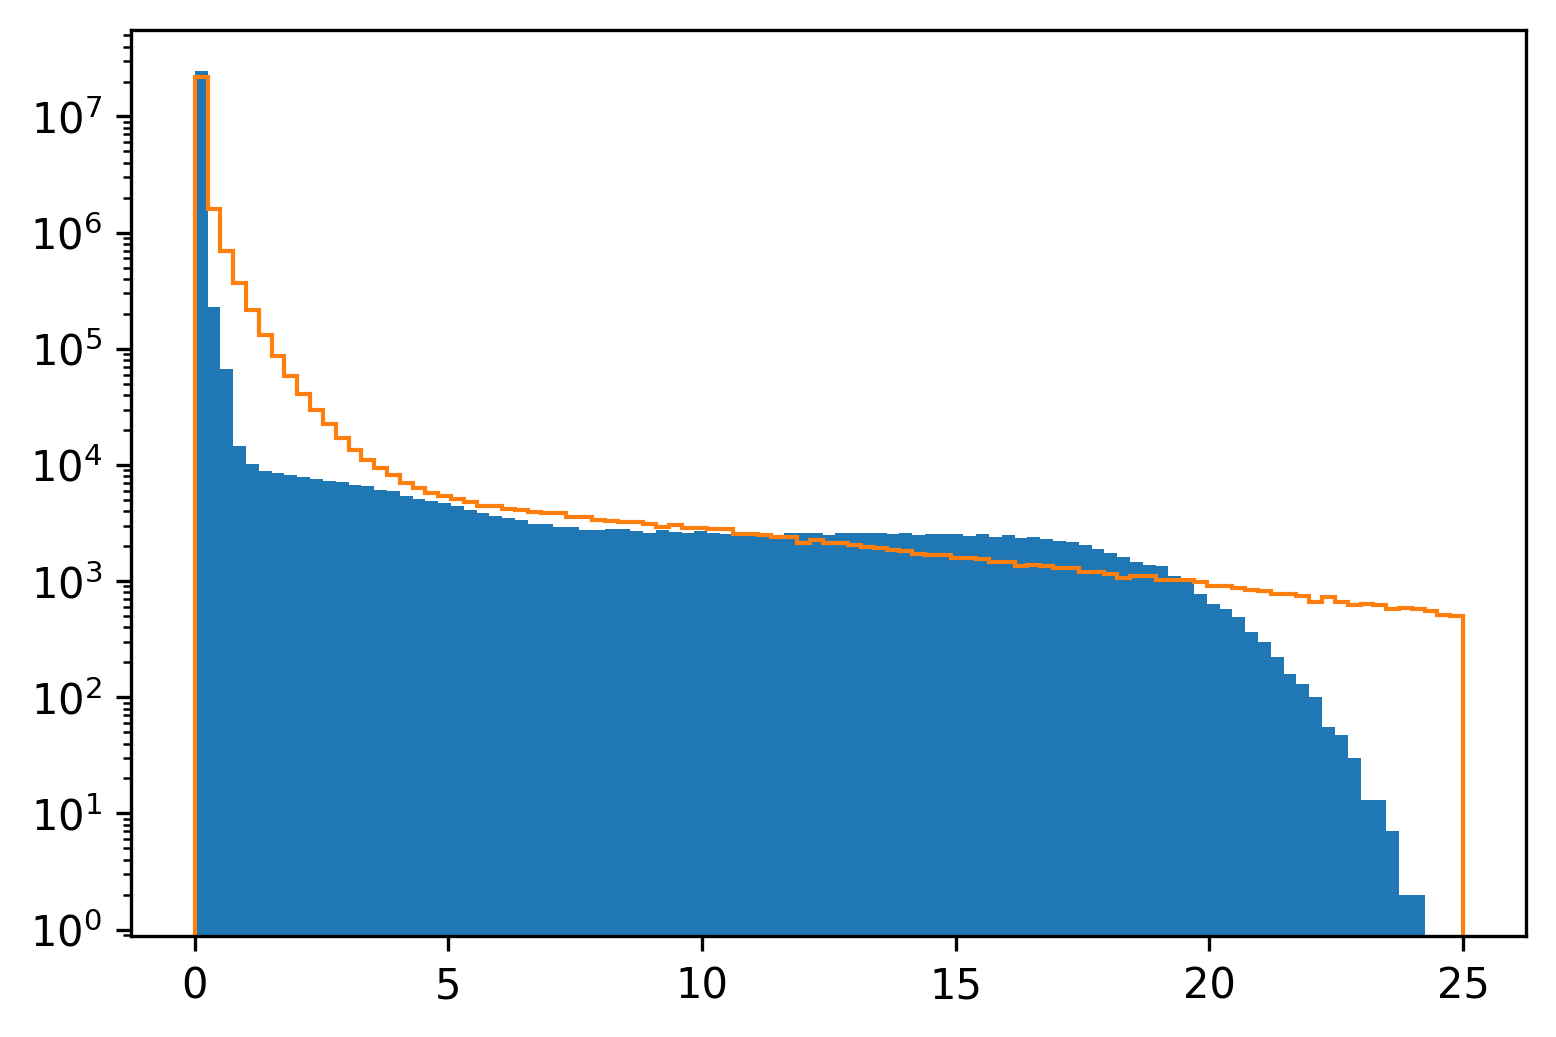

In [38]:
plt.hist(gen_voxels.flatten(), bins=np.linspace(0,25,100),log=True)
plt.hist(flow_voxels.flatten(), bins=np.linspace(0,25,100),log=True,histtype='step')

In [11]:
np.count_nonzero(gen_voxels.flatten())

8081590

In [39]:
flow_voxels[flow_voxels<5e-2]=0
np.count_nonzero(flow_voxels.flatten())

7868933

In [40]:
gen_layer0 = gen_elayers[:,0]
gen_layer1 = gen_elayers[:,1]
gen_layer2 = gen_elayers[:,2]

In [41]:
flow_layer0 = flow_elayers[:,0]
flow_layer1 = flow_elayers[:,1]
flow_layer2 = flow_elayers[:,2]

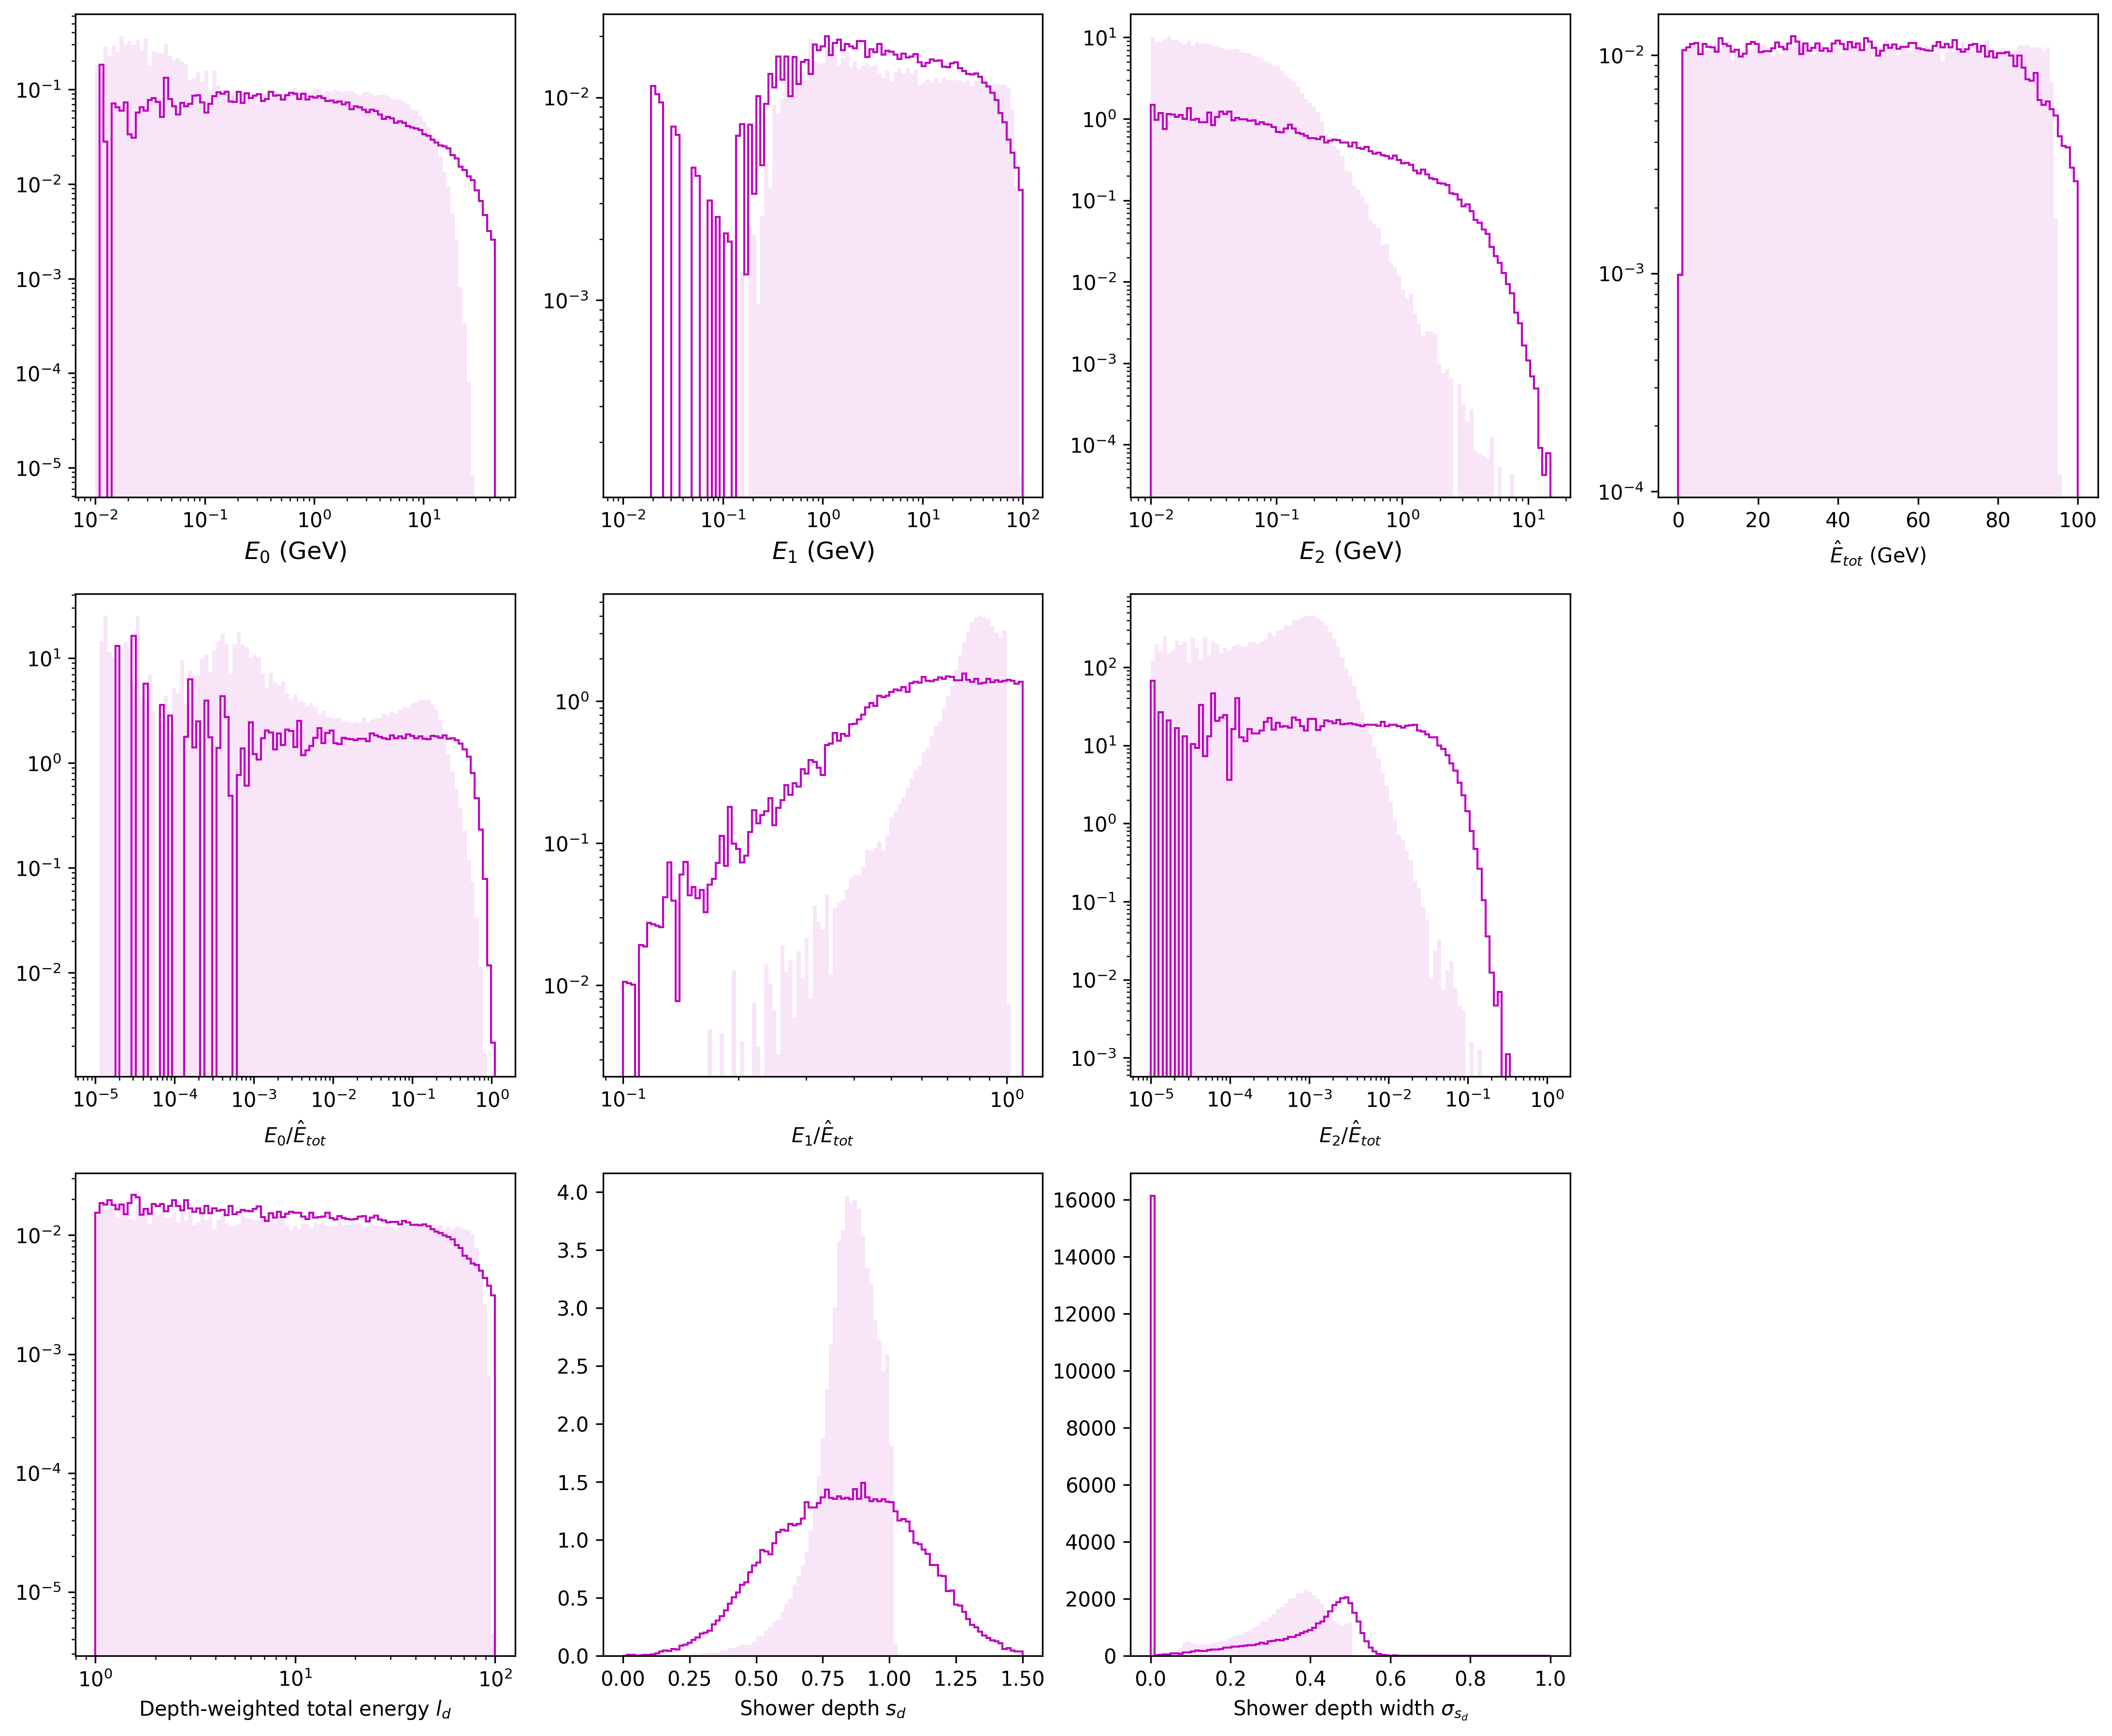

In [42]:
plt.rcParams['figure.dpi'] = 300

def plot_flow1_hists(layer0, layer1, layer2,
                     layer0_sampled, layer1_sampled, layer2_sampled):
    Etot = layer0 + layer1 + layer2
    Etot_sampled = layer0_sampled + layer1_sampled + layer2_sampled
    
    fig = plt.figure(figsize=(18, 15))
    plt.subplot(341)
    plt.hist(layer0, bins=np.geomspace(0.01, 45, 100), label='GEANT4', color='m', log=True,
             alpha=0.1, density=True)
    plt.hist(layer0_sampled, bins=np.geomspace(0.01, 45, 100), histtype='step', color='m',
             label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('$E_0$ (GeV)', fontsize=12)
    
    plt.subplot(342)
    plt.hist(layer1, bins=np.geomspace(0.01, 100, 100), label='GEANT4', color='m', log=True,
             alpha=0.1, density=True)
    plt.hist(layer1_sampled, bins=np.geomspace(0.01, 100, 100), histtype='step', color='m',
             label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('$E_1$ (GeV)', fontsize=12)
    
    plt.subplot(343)
    plt.hist(layer2, bins=np.geomspace(0.01, 15, 100), label='GEANT4', color='m', log=True,
             alpha=0.1, density=True)
    plt.hist(layer2_sampled, bins=np.geomspace(0.01, 15, 100), histtype='step', color='m',
             label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('$E_2$ (GeV)', fontsize=12)
    
    plt.subplot(345)
    plt.hist(layer0/Etot, bins=np.geomspace(0.00001, 1.1, 100), label='GEANT4', color='m',
             log=True, alpha=0.1, density=True)
    plt.hist(layer0_sampled/Etot_sampled, bins=np.geomspace(0.00001, 1.1, 100), histtype='step',
             color='m', label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('$E_0$/$\hat{E}_{tot}$')
    
    plt.subplot(346)
    plt.hist(layer1/Etot, bins=np.geomspace(0.1, 1.1, 100), label='GEANT4', color='m',
             log=True, alpha=0.1, density=True)
    plt.hist(layer1_sampled/Etot_sampled, bins=np.geomspace(0.1, 1.1, 100), histtype='step',
             color='m', label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('$E_1$/$\hat{E}_{tot}$')
    
    plt.subplot(347)
    plt.hist(layer2/Etot, bins=np.geomspace(0.00001, 1.1, 100), label='GEANT4', color='m',
             log=True, alpha=0.1, density=True)
    plt.hist(layer2_sampled/Etot_sampled, bins=np.geomspace(0.00001, 1.1, 100), histtype='step',
             color='m', label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('$E_2$/$\hat{E}_{tot}$')
    
    plt.subplot(344)
    plt.hist(Etot, bins=np.linspace(0, 100, 100), label='GEANT4', color='m', log=True,
             alpha=0.1, density=True)
    plt.hist(Etot_sampled, bins=np.linspace(0, 100, 100), histtype='step',
             color='m', label='FFJORD', log=True, density=True)
    plt.xlabel('$\hat{E}_{tot}$ (GeV)')
    
    plt.subplot(349)
    ld = layer1 + 2*layer2
    ld_sampled = layer1_sampled + 2*layer2_sampled
    plt.hist(ld, bins=np.geomspace(1, 100, 100), label='GEANT4', color='m', log=True,
             alpha=0.1, density=True)
    plt.hist(ld_sampled, bins=np.geomspace(1, 100, 100), histtype='step', color='m',
             label='FFJORD', log=True, density=True)
    plt.xscale('log')
    plt.xlabel('Depth-weighted total energy $l_d$')
    
    plt.subplot(3,4,10)
    sd, sd_sampled = ld/Etot, ld_sampled/Etot_sampled
    plt.hist(sd, bins=np.linspace(0, 1.5, 100), label='GEANT4', color='m', alpha=0.1,
            density=True)
    plt.hist(sd_sampled, bins=np.linspace(0, 1.5, 100), histtype='step', color='m',
             label='FFJORD', density=True)
    plt.xlabel('Shower depth $s_d$')
    
    ld2 = layer1 + 4*layer2
    ld2_sampled = layer1_sampled + 4*layer2_sampled
    plt.subplot(3,4,11)
    plt.hist(np.ma.sqrt(ld2/Etot - sd ** 2).filled(0), bins=np.linspace(0,1,100), color='m', alpha=0.1,
             label='GEANT4')
    plt.hist(np.ma.sqrt(ld2_sampled/Etot - sd_sampled ** 2).filled(0), bins=np.linspace(0,1,100), histtype='step', color='m',\
             label='FFJORD')
    plt.xlabel('Shower depth width $\sigma_{s_d}$')

plot_flow1_hists(gen_layer0, gen_layer1, gen_layer2, flow_layer0, flow_layer1, flow_layer2)

In [43]:
def plot_event_one_model(i, energy_voxel, voxels_sampled, filename='event.pdf', display=True):
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.subplot(231)
    plt.imshow(energy_voxel[i][:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.ylabel("GEANT4")
    plt.subplot(232)
    plt.imshow(energy_voxel[i][288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.subplot(233)
    plt.imshow(energy_voxel[i][432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.subplot(234)
    img0 = voxels_sampled[i][:288].reshape((3,96))
    #img0[img0 < 1e-3] = 0
    plt.imshow(img0, aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.ylabel("FFJORD")
    plt.xlabel("layer 0")
    plt.subplot(235)
    img1 = voxels_sampled[i][288:432].reshape((12,12))
    #img1[img1 < 1e-3] = 0
    plt.imshow(img1, aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.xlabel("layer 1")
    plt.subplot(236)
    img2 = voxels_sampled[i][432:].reshape((12,6))
    #img2[img2 < 1e-3] = 0
    plt.imshow(img2, aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.xlabel("layer 2")

    plt.suptitle(f"Event {i}, True energy {gen_etot[i][0]} GeV")
    cax = plt.axes([0.85, 0.1, 0.025, 0.8])
    plt.colorbar(cax=cax)
    plt.ylabel("energy (GeV)")
    if not display:
        plt.close()
    fig.savefig('../plots/{}'.format(filename))

def calculate_avg_img(voxel_arr):
    images = []
    for i, voxels in enumerate(voxel_arr):
        images.append(np.concatenate((voxels[:288], voxels[288:432], voxels[432:])))
    images = np.array(images)
    return images.mean(axis=0)

def plot_avg_img_one_model(energy_voxel, voxels_sampled, filename='avg.pdf', display=True):
    avg_image = calculate_avg_img(energy_voxel)
    avg_1 = calculate_avg_img(voxels_sampled)
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.subplot(231)
    plt.imshow(avg_image[:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.ylabel("GEANT4")
    plt.subplot(232)
    plt.imshow(avg_image[288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.subplot(233)
    plt.imshow(avg_image[432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.subplot(234)
    plt.imshow(avg_1[:288].reshape((3,96)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.ylabel("FFJORD")
    plt.xlabel("layer 0")
    plt.subplot(235)
    plt.imshow(avg_1[288:432].reshape((12,12)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.xlabel("layer 1")
    plt.subplot(236)
    plt.imshow(avg_1[432:].reshape((12,6)), aspect='auto', norm=colors.LogNorm(1e-5,1e1))
    plt.xlabel("layer 2")

    plt.suptitle("Average image")
    cax = plt.axes([0.85, 0.1, 0.025, 0.8])
    plt.colorbar(cax=cax)
    plt.ylabel("energy (GeV)")
    if not display:
        plt.close()
    fig.savefig('../plots/{}'.format(filename))

def plot_flow2_hists(energy_voxel, voxels_sampled):
    fig = plt.figure(figsize=(15, 18))
    E1b0, E1b1, E1b2 = [], [], []
    E2b0, E2b1, E2b2 = [], [], []
    E1b0s, E1b1s, E1b2s = [], [], []
    E2b0s, E2b1s, E2b2s = [], [], []
    Eratio0, Eratio1, Eratio2 = [], [], []
    spar0, spar1, spar2 = [], [], []
    Eratio0s, Eratio1s, Eratio2s = [], [], []
    spar0s, spar1s, spar2s = [], [], []
    for voxels in energy_voxel:
        l0 = np.sort(np.ma.divide(voxels[:288], np.sum(voxels[:288])).filled(0))
        l1 = np.sort(np.ma.divide(voxels[288:432], np.sum(voxels[288:432])).filled(0))
        l2 = np.sort(np.ma.divide(voxels[432:], np.sum(voxels[432:])).filled(0))
        E1b0.append(l0[-1])
        E1b1.append(l1[-1])
        E1b2.append(l2[-1])
        E2b0.append(l0[-2])
        E2b1.append(l1[-2])
        E2b2.append(l2[-2])
        if l0[-1] + l0[-2] == 0: Eratio0.append(0)
        else: Eratio0.append((l0[-1] - l0[-2])/(l0[-1] + l0[-2]))
        if l1[-1] + l1[-2] == 0: Eratio1.append(0)
        else: Eratio1.append((l1[-1] - l1[-2])/(l1[-1] + l1[-2]))
        if l2[-1] + l2[-2] == 0: Eratio2.append(0)
        else: Eratio2.append((l2[-1] - l2[-2])/(l2[-1] + l2[-2]))
        spar0.append(np.count_nonzero(l0)/288)
        spar1.append(np.count_nonzero(l1)/144)
        spar2.append(np.count_nonzero(l2)/72)
    
    for voxels in voxels_sampled:
        l0 = np.sort(np.ma.divide(voxels[:288], np.sum(voxels[:288])).filled(0))
        l1 = np.sort(np.ma.divide(voxels[288:432], np.sum(voxels[288:432])).filled(0))
        l2 = np.sort(np.ma.divide(voxels[432:], np.sum(voxels[432:])).filled(0))
        E1b0s.append(l0[-1])
        E1b1s.append(l1[-1])
        E1b2s.append(l2[-1])
        E2b0s.append(l0[-2])
        E2b1s.append(l1[-2])
        E2b2s.append(l2[-2])
        if l0[-1] + l0[-2] == 0: Eratio0s.append(0)
        else: Eratio0s.append((l0[-1] - l0[-2])/(l0[-1] + l0[-2]))
        if l1[-1] + l1[-2] == 0: Eratio1s.append(0)
        else: Eratio1s.append((l1[-1] - l1[-2])/(l1[-1] + l1[-2]))
        if l2[-1] + l2[-2] == 0: Eratio2s.append(0)
        else: Eratio2s.append((l2[-1] - l2[-2])/(l2[-1] + l2[-2]))
        spar0s.append(np.count_nonzero(l0)/288)
        spar1s.append(np.count_nonzero(l1)/144)
        spar2s.append(np.count_nonzero(l2)/72)
        
    plt.subplot(431)
    #plt.hist(E1b0s)
    plt.hist(E1b0, bins=np.linspace(0,1.1,100), color='m', alpha=0.1, density=True)
    plt.hist(E1b0s, bins=np.linspace(0,1.1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{1,brightest,0}$")
    plt.subplot(432)
    plt.hist(E1b1, bins=np.linspace(0,1.1,100), color='m', alpha=0.1, density=True)
    plt.hist(E1b1s, bins=np.linspace(0,1.1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{1,brightest,1}$")
    plt.subplot(433)
    plt.hist(E1b2, bins=np.linspace(0,1.1,100), color='m', alpha=0.1, density=True)
    plt.hist(E1b2s, bins=np.linspace(0,1.1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{1,brightest,2}$")
    plt.subplot(434)
    plt.hist(E2b0, bins=np.linspace(0,0.6,100), color='m', alpha=0.1, density=True)
    plt.hist(E2b0s, bins=np.linspace(0,0.6,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{2,brightest,0}$")
    plt.subplot(435)
    plt.hist(E2b1, bins=np.linspace(0,0.4,100), color='m', alpha=0.1, density=True)
    plt.hist(E2b1s, bins=np.linspace(0,0.4,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{2,brightest,1}$")
    plt.subplot(436)
    plt.hist(E2b2, bins=np.linspace(0,1.1,100), color='m', alpha=0.1, density=True)
    plt.hist(E2b2s, bins=np.linspace(0,1.1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{2,brightest,2}$")
    plt.subplot(437)
    plt.hist(Eratio0, bins=np.linspace(0,1,100), color='m', alpha=0.1, density=True)
    plt.hist(Eratio0s, bins=np.linspace(0,1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{ratio,0}$")
    plt.subplot(438)
    plt.hist(Eratio1, bins=np.linspace(0,1,100), color='m', alpha=0.1, density=True)
    plt.hist(Eratio1s, bins=np.linspace(0,1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{ratio,1}$")
    plt.subplot(439)
    plt.hist(Eratio2, bins=np.linspace(0,1,100), color='m', alpha=0.1, density=True)
    plt.hist(Eratio2s, bins=np.linspace(0,1,100), color='m', histtype='step', density=True)
    plt.xlabel("$E_{ratio,2}$")
    plt.subplot(4,3,10)
    plt.hist(spar0, bins=np.linspace(0,1,20), color='m', alpha=0.1, density=True)
    plt.hist(spar0s, bins=np.linspace(0,1,20), color='m', histtype='step', density=True)
    plt.xlabel("Sparsity in layer 0")
    plt.subplot(4,3,11)
    plt.hist(spar1, bins=np.linspace(0,1,20), color='m', alpha=0.1, density=True)
    plt.hist(spar1s, bins=np.linspace(0,1,20), color='m', histtype='step', density=True)
    plt.xlabel("Sparsity in layer 1")
    plt.subplot(4,3,12)
    plt.hist(spar2, bins=np.linspace(0,1,20), color='m', alpha=0.1, density=True)
    plt.hist(spar2s, bins=np.linspace(0,1,20), color='m', histtype='step', density=True)
    plt.xlabel("Sparsity in layer 2")

def plot_flow2_shape_hists(energy_voxel, voxels_sampled):
    fig = plt.figure(figsize=(15, 15))
    H0 = np.full((3, 96), np.linspace(0,475,96)+2.5).flatten() - 240.0
    H1 = np.full((12, 12), np.linspace(0,440,12)+20.0).flatten() - 240.0
    H2 = np.full((12, 6), np.linspace(0,400,6)+40.0).flatten() - 240.0
    F0 = np.full((96, 3), np.linspace(0,320,3)+80.0).T.flatten() - 240.0
    F1 = np.full((12, 12), np.linspace(0,440,12)+20.0).T.flatten() - 240.0
    F2 = np.full((6, 12), np.linspace(0,440,12)+20.0).T.flatten() - 240.0
    eta0, eta1, eta2 = [], [], []
    phi0, phi1, phi2 = [], [], []
    sigma0, sigma1, sigma2 = [], [], []
    eta0s, eta1s, eta2s = [], [], []
    phi0s, phi1s, phi2s = [], [], []
    sigma0s, sigma1s, sigma2s = [], [], []
    for voxels in energy_voxel:
        l0 = np.ma.divide(voxels[:288], np.sum(voxels[:288])).filled(0)
        l1 = np.ma.divide(voxels[288:432], np.sum(voxels[288:432])).filled(0)
        l2 = np.ma.divide(voxels[432:], np.sum(voxels[432:])).filled(0)
        eta0.append(sum(l0*H0))
        eta1.append(sum(l1*H1))
        eta2.append(sum(l2*H2))
        phi0.append(sum(l0*F0))
        phi1.append(sum(l1*F1))
        phi2.append(sum(l2*F2))
        sigma0.append(sum(np.sqrt(l0 * H0**2 - (l0*H0)**2)))
        sigma1.append(sum(np.sqrt(l1 * H1**2 - (l1*H1)**2)))
        sigma2.append(sum(np.sqrt(l2 * H2**2 - (l2*H2)**2)))
    
    for voxels in voxels_sampled:
        l0 = np.ma.divide(voxels[:288], np.sum(voxels[:288])).filled(0)
        l1 = np.ma.divide(voxels[288:432], np.sum(voxels[288:432])).filled(0)
        l2 = np.ma.divide(voxels[432:], np.sum(voxels[432:])).filled(0)
        eta0s.append(sum(l0*H0))
        eta1s.append(sum(l1*H1))
        eta2s.append(sum(l2*H2))
        phi0s.append(sum(l0*F0))
        phi1s.append(sum(l1*F1))
        phi2s.append(sum(l2*F2))
        sigma0s.append(sum(np.sqrt(l0 * H0**2 - (l0*H0)**2)))
        sigma1s.append(sum(np.sqrt(l1 * H1**2 - (l1*H1)**2)))
        sigma2s.append(sum(np.sqrt(l2 * H2**2 - (l2*H2)**2)))
    
    plt.subplot(331)
    plt.hist(phi0, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(phi0s, bins=np.linspace(-100,100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\langle\phi_0\rangle$')
    plt.subplot(332)
    plt.hist(phi1, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(phi1s, bins=np.linspace(-100,100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\langle\phi_1\rangle$')
    plt.subplot(333)
    plt.hist(phi2, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(phi2s, bins=np.linspace(-100,100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\langle\phi_2\rangle$')
    plt.subplot(334)
    plt.hist(eta0, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(eta0s, bins=np.linspace(-100,100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\langle\eta_0\rangle$')
    plt.subplot(335)
    plt.hist(eta1, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(eta1s, bins=np.linspace(-100,100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\langle\eta_1\rangle$')
    plt.subplot(336)
    plt.hist(eta2, bins=np.linspace(-100,100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(eta2s, bins=np.linspace(-100,100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\langle\eta_2\rangle$')
    plt.subplot(337)
    plt.hist(sigma0, bins=np.geomspace(1,2000,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(sigma0s, bins=np.geomspace(1,2000,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\sigma_0$')
    plt.xscale('log')
    plt.subplot(338)
    plt.hist(sigma1, bins=np.geomspace(1,1500,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(sigma1s, bins=np.geomspace(1,1500,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\sigma_1$')
    plt.xscale('log')
    plt.subplot(339)
    plt.hist(sigma2, bins=np.geomspace(1,1100,100), color='m', alpha=0.1, log=True, density=True)
    plt.hist(sigma2s, bins=np.geomspace(1,1100,100), color='m', histtype='step', log=True, density=True)
    plt.xlabel(r'$\sigma_2$')
    plt.xscale('log')

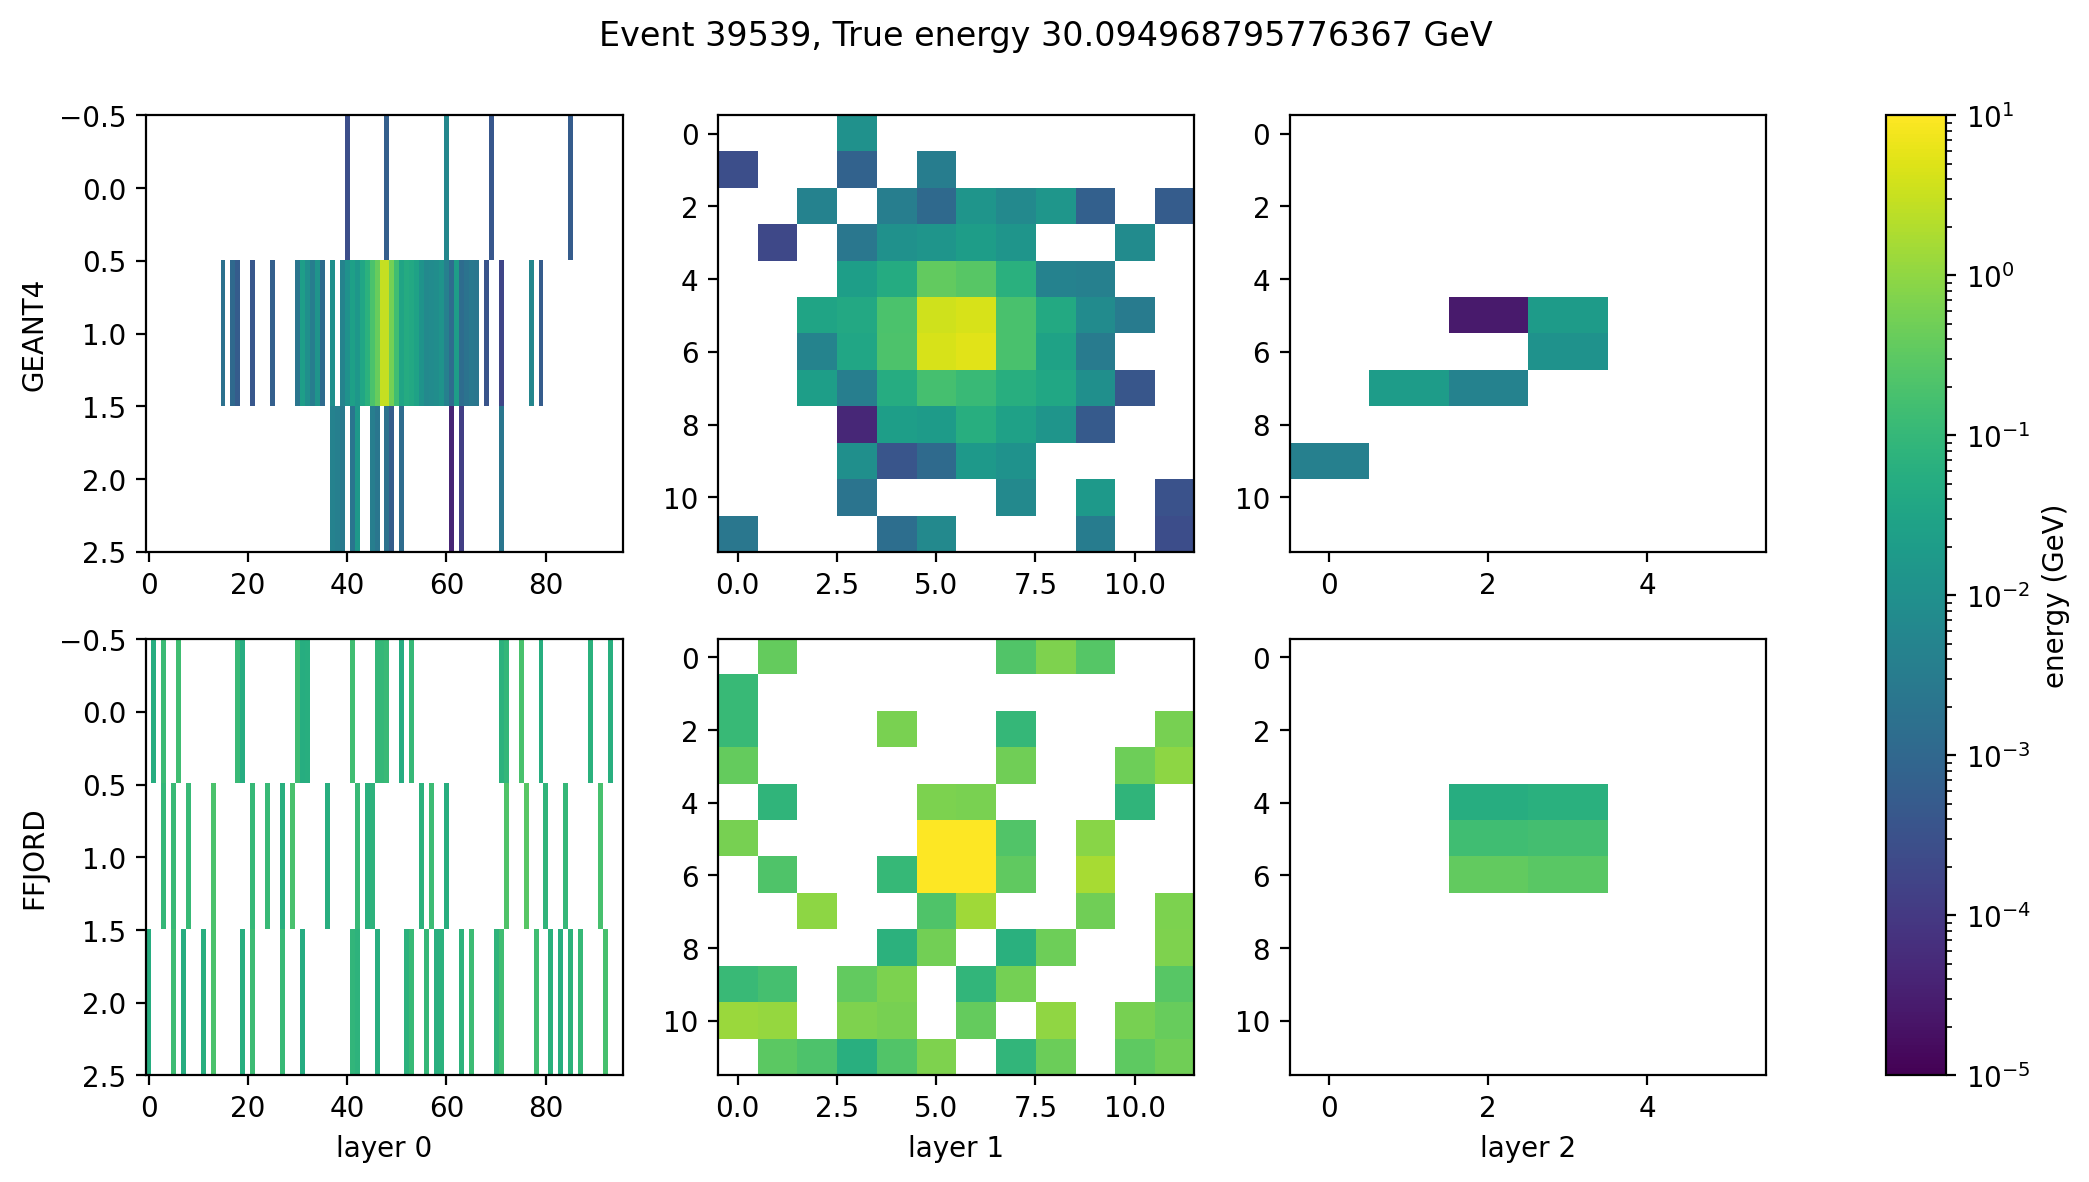

In [44]:
import matplotlib.colors as colors
plt.rcParams['figure.dpi'] = 200

i = np.random.randint(nevts)
plot_event_one_model(i, gen_voxels, flow_voxels)

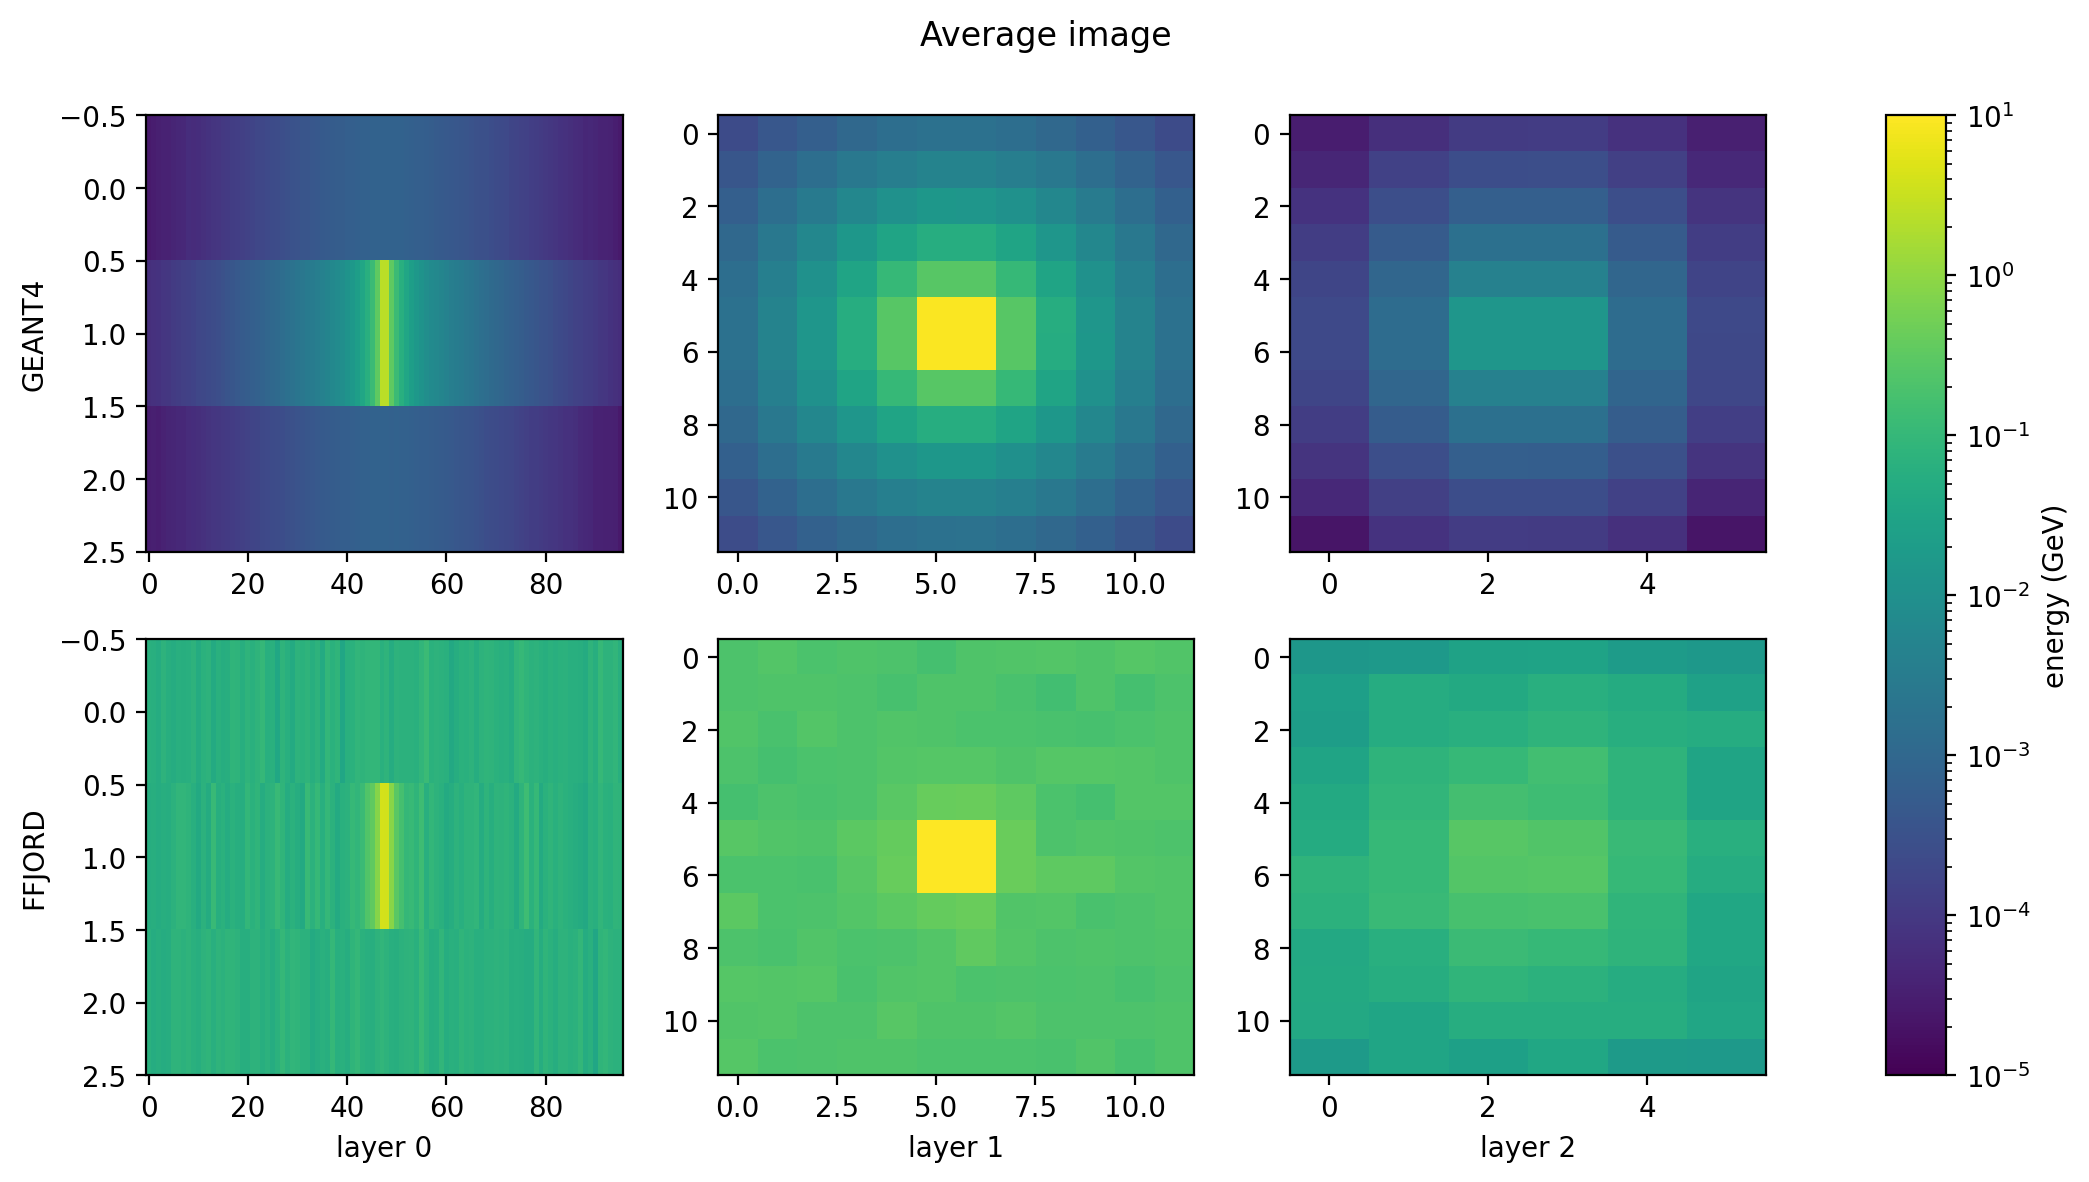

In [45]:
plot_avg_img_one_model(gen_voxels, flow_voxels)

CPU times: user 21.7 s, sys: 356 µs, total: 21.7 s
Wall time: 21.6 s


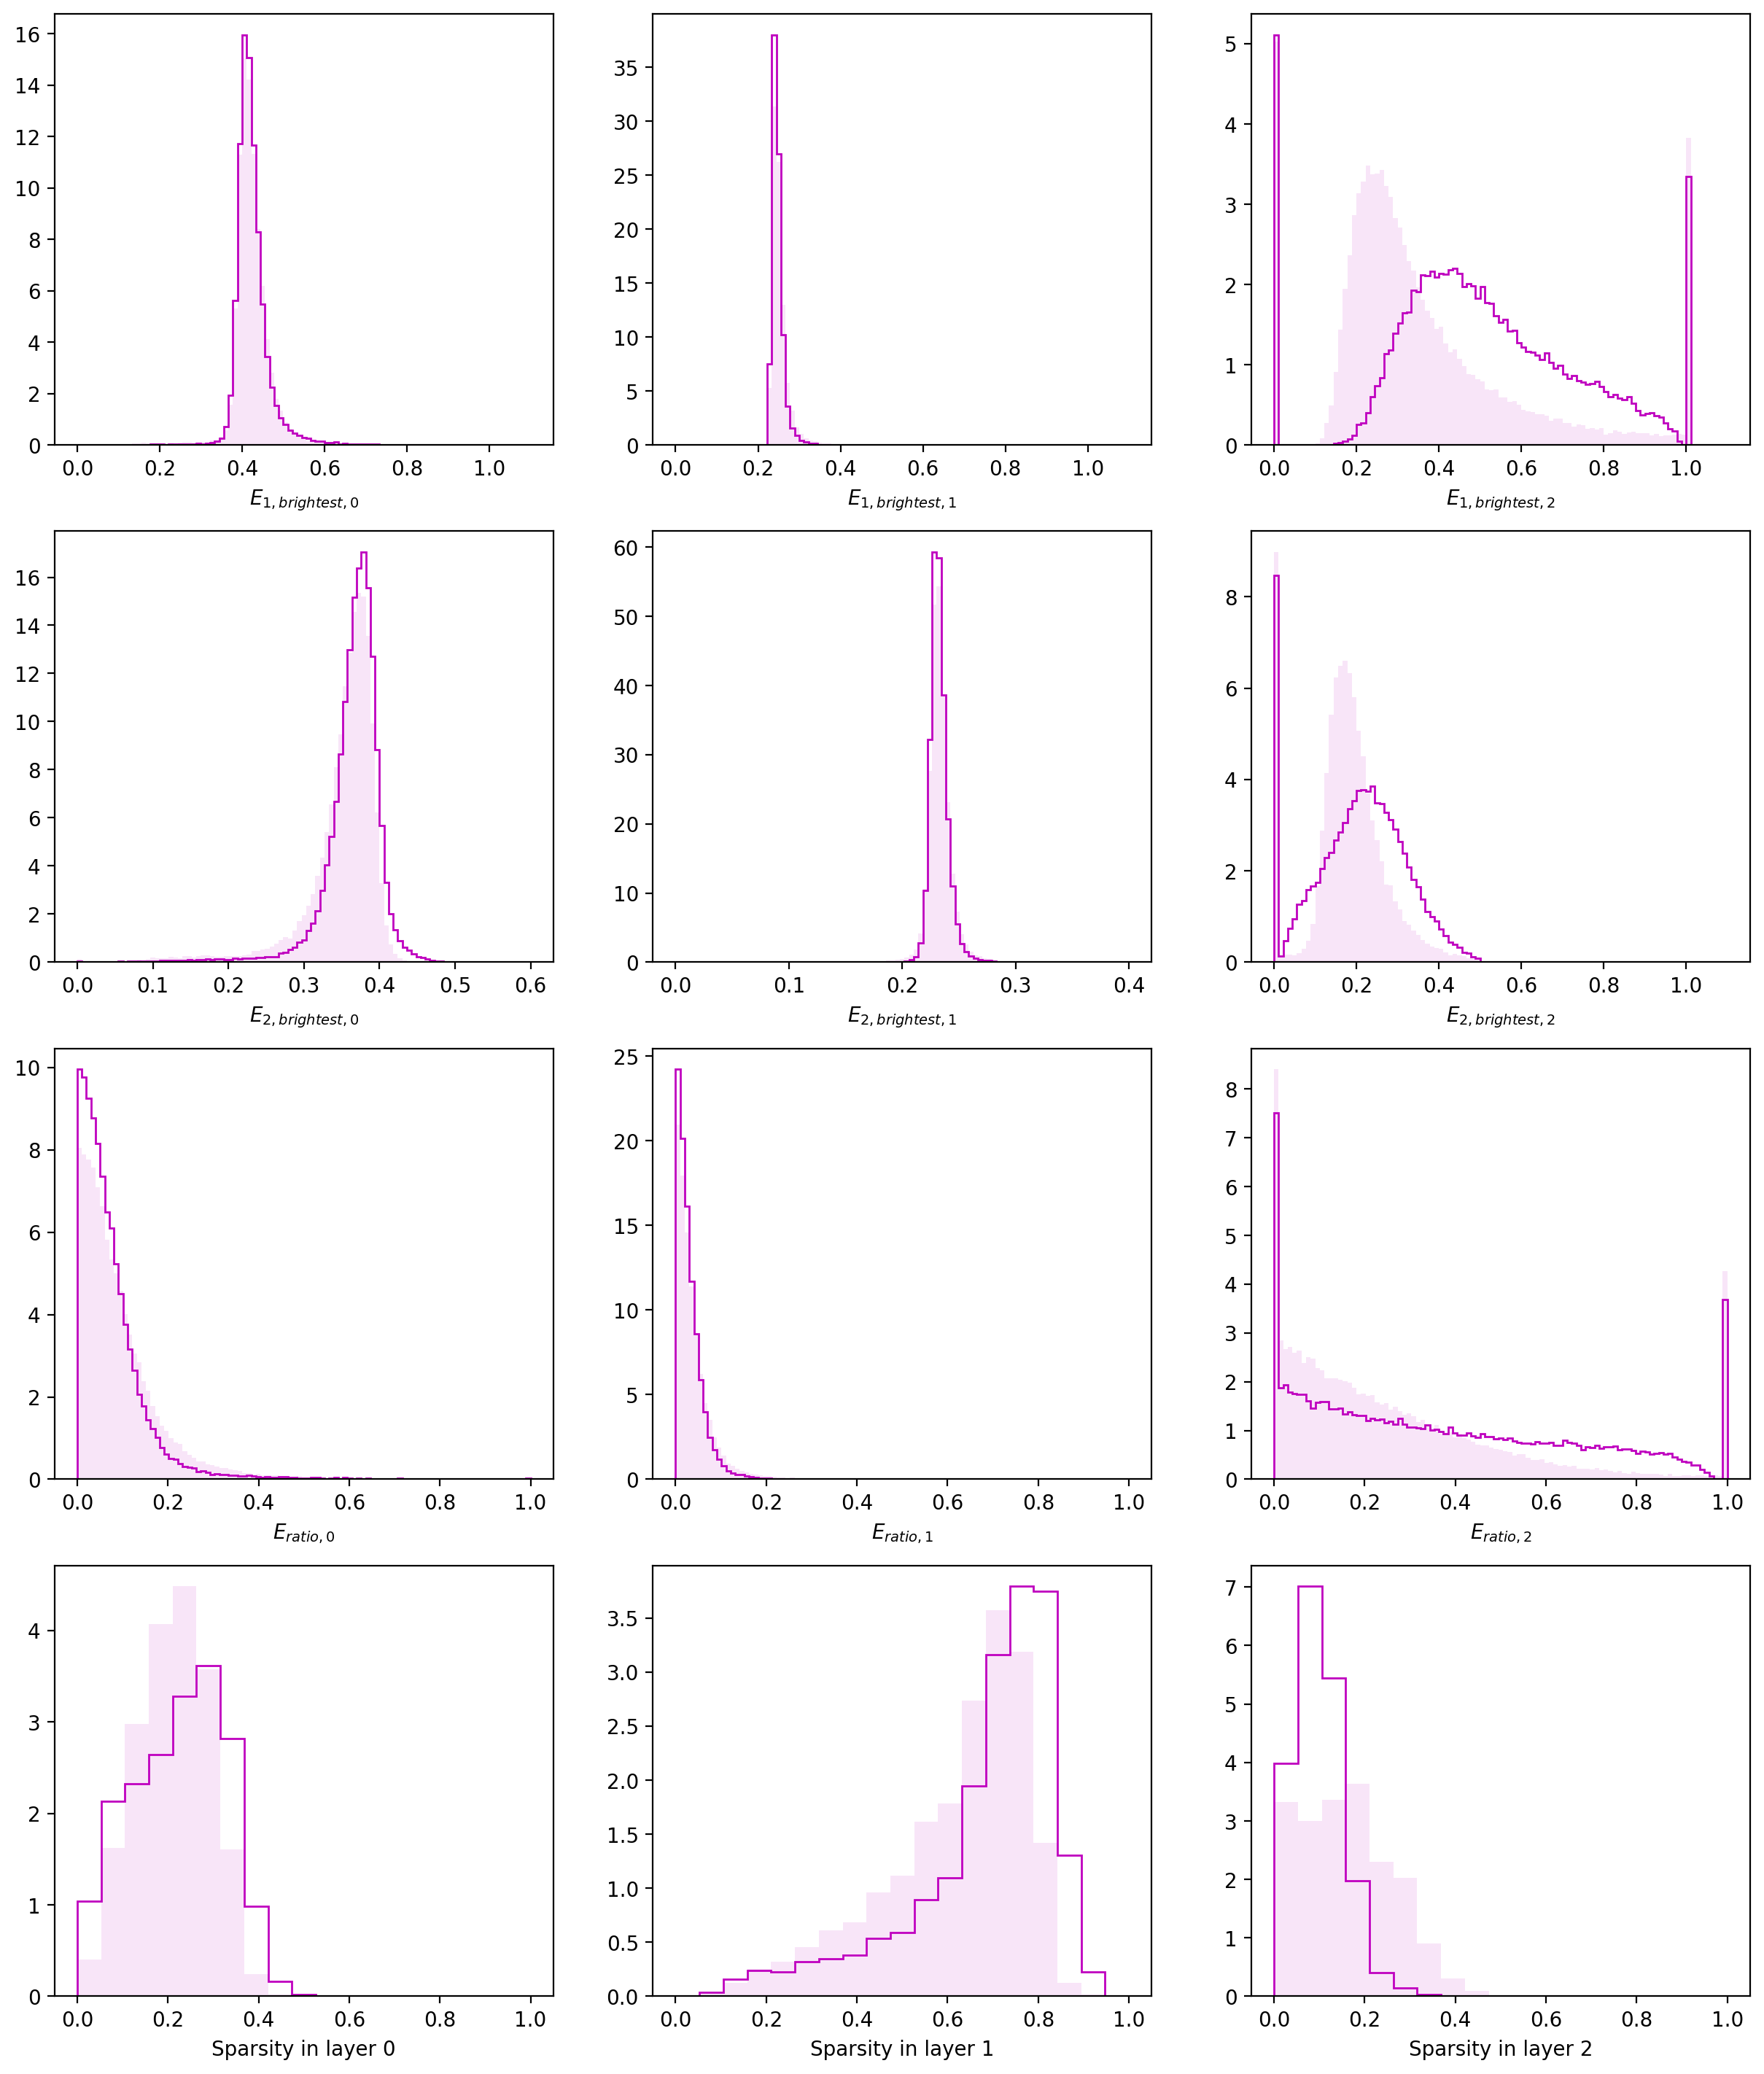

In [68]:
%%time
plot_flow2_hists(gen_voxels, flow_voxels)

CPU times: user 40.9 s, sys: 260 ms, total: 41.2 s
Wall time: 40.8 s


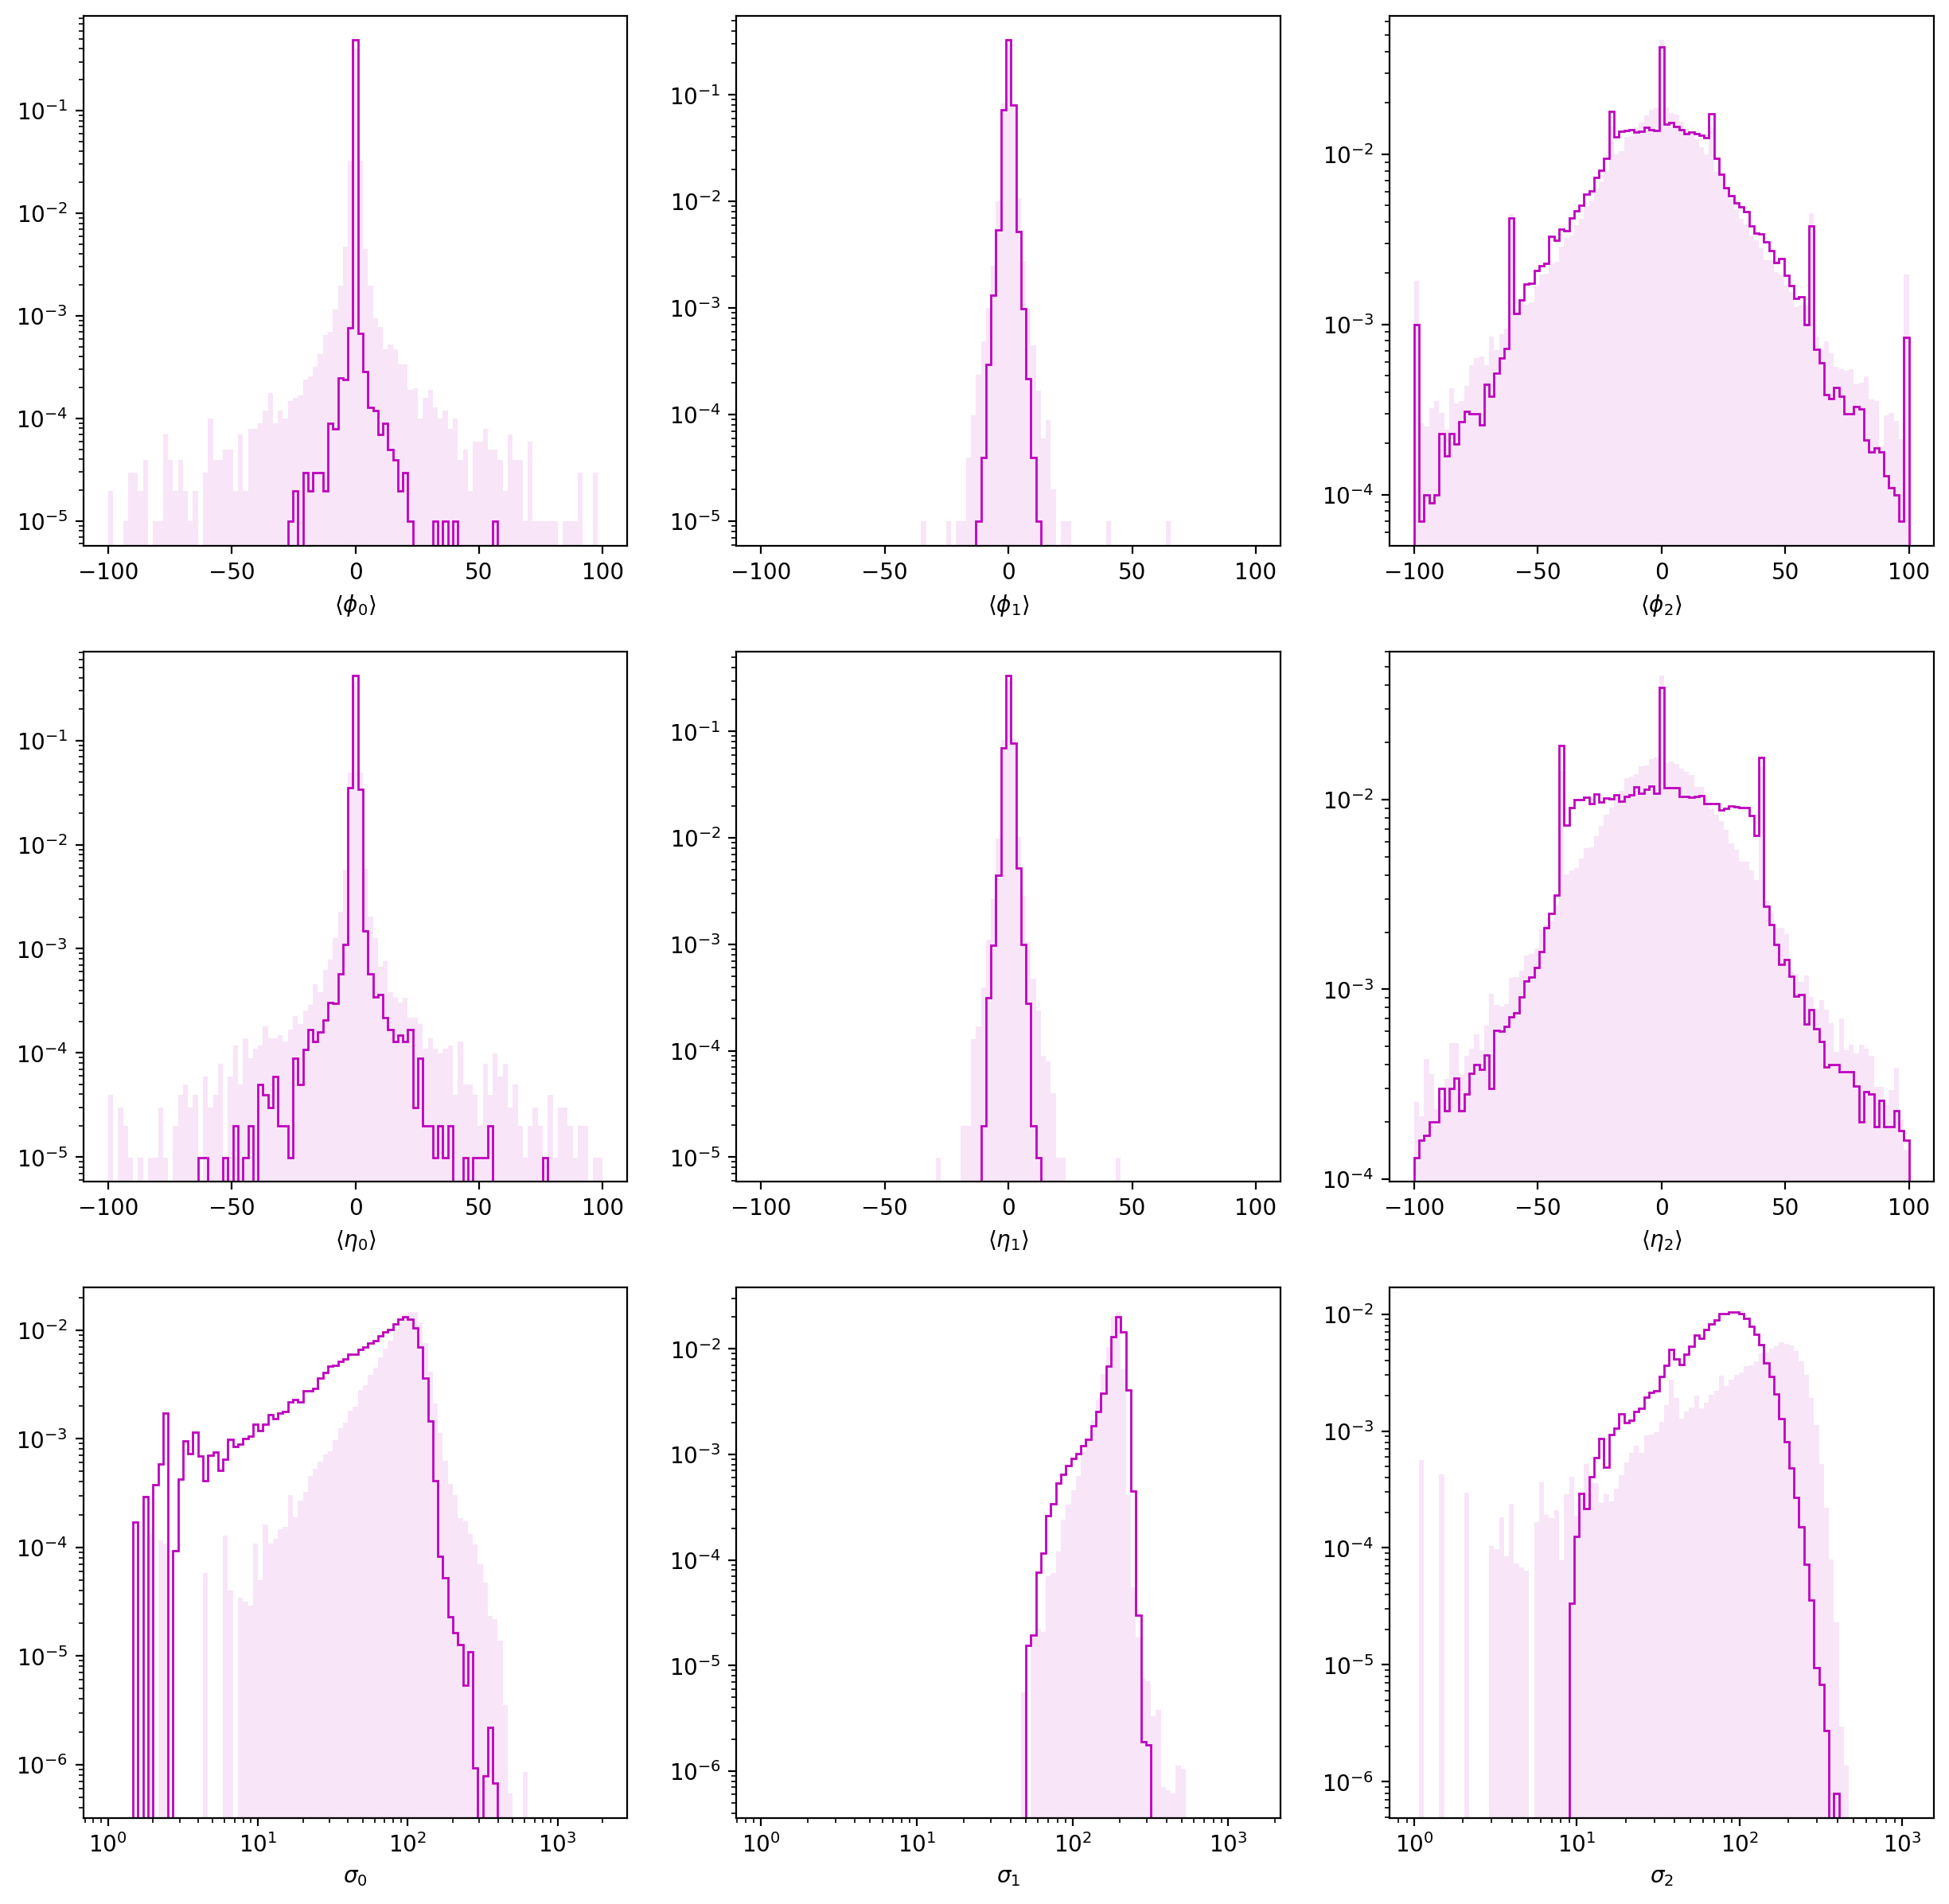

In [69]:
%%time
plot_flow2_shape_hists(gen_voxels, flow_voxels)

In [70]:
def Classifier(data_dict):
    from tensorflow import keras
    train = np.concatenate([data_dict['Geant4'][1], data_dict['FFJORD'][1]],0)
    labels = np.concatenate([np.zeros((data_dict['Geant4'][1].shape[0],1)),
                             np.ones((data_dict['FFJORD'][1].shape[0],1))],0)
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss="binary_crossentropy",
                  metrics=['accuracy'])

    model.fit(train, labels, epochs=10)

In [72]:
Classifier(data_dict)

Epoch 1/10
3125/3125 [==============================] - 3s 821us/step - loss: 0.5140 - accuracy: 0.7236
Epoch 2/10
3125/3125 [==============================] - 3s 821us/step - loss: 0.2477 - accuracy: 0.9058
Epoch 3/10
2299/3125 [=====================>........] - ETA: 0s - loss: 0.1991 - accuracy: 0.9240

KeyboardInterrupt: 

## Inference

In [36]:
%%time
event0 = np.concatenate([gen_energy_voxel[0], gen_energy_layer[0]]).reshape((1,507))
event = np.concatenate([event0, event0])
en0 = energy[0].reshape((1,1))
en = np.concatenate([en0, en0])
print(event.shape)
print(en.shape)
model.conditional_log_prob(event, en)

(2, 507)
(2, 1)
CPU times: user 4.28 s, sys: 0 ns, total: 4.28 s
Wall time: 4.21 s


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1514.5211, -1551.9044], dtype=float32)>

In [75]:
print(np.max(event))
print(np.min(event))
print(np.max(points))
print(np.min(points))

5.9476376
-13.815472
nan
nan


In [6]:
energy, gen_energy_layer, gen_energy_voxel = preprocessing.DataLoader(file_path,nevts)

def ReverseNorm(e,e_layer,e_voxel):
    '''Revert the transformations applied to the training set'''    
    alpha = 1e-6
    
    gen_energy = 10**(e+1)
    # layer_norm = 10**(e_layer)*gen_energy

    exp = np.exp(e_layer)    
    x = exp/(1+exp)
    u_norm = (x-alpha)/(1 - 2*alpha)
    
    layer_norm= np.zeros(u_norm.shape,dtype=np.float32)
    layer_norm[:,0] = np.squeeze(gen_energy)*u_norm[:,0]*u_norm[:,1]
    layer_norm[:,1] = np.squeeze(gen_energy)*u_norm[:,0]*u_norm[:,2]*(1-u_norm[:,1])
    layer_norm[:,2] = np.squeeze(gen_energy)*u_norm[:,0]*(1-u_norm[:,1])*(1-u_norm[:,2])

    
    exp = np.exp(e_voxel)    
    x = exp/(1+exp)
    voxel = (x-alpha)/(1 - 2*alpha)
    voxel[:,:288] = voxel[:,:288] * np.expand_dims(layer_norm[:,0],-1)/np.sum(voxel[:,:288],-1,keepdims=True)
    voxel[:,288:432] = voxel[:,288:432] * np.expand_dims(layer_norm[:,1],-1)/np.sum(voxel[:,288:432],-1,keepdims=True)
    voxel[:,432:] = voxel[:,432:] * np.expand_dims(layer_norm[:,2],-1)/np.sum(voxel[:,432:],-1,keepdims=True)
    
    return gen_energy, layer_norm, voxel

In [7]:
def jacobian(v0, v1, v2, Etot, alpha):
    return -(np.exp(v0+v1+v2) * (alpha + (alpha-1)*np.exp(v0))**2 * (alpha*np.exp(v1)+alpha-1) * Etot**3)/\
            ((1-2*alpha)**6 * (1+np.exp(v0))**4 * (1+np.exp(v1))**3 * (1+np.exp(v2))**2)

entering scanner


<timed exec>:4: RuntimeWarning: invalid value encountered in log


-1.0 0.5284314
CPU times: user 17min 15s, sys: 649 ms, total: 17min 15s
Wall time: 17min 12s


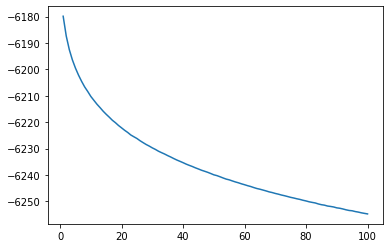

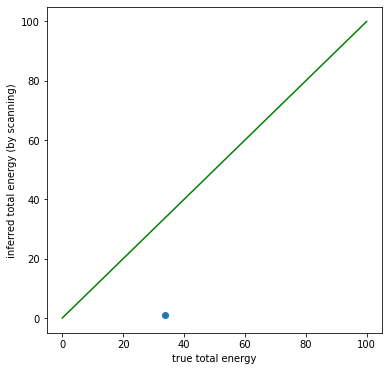

In [10]:
%%time
def preprocess_flow2(N, e0, e1, e2, energy, energy_voxel, alpha):
    #print(N, layer0, layer1, layer2, energy, alpha)
    x = alpha + (1 - 2*alpha) * energy_voxel
    v = np.log(x/(1-x))
    etot = energy.reshape(N,)
    etot_log = np.log10(etot/10)
    e0_log = np.log10((e0 + 0.001)/100000) + 2
    e1_log = np.log10((e1 + 0.001)/100000) + 2
    e2_log = np.log10((e2 + 0.001)/100000) + 2
    conds = np.stack([e0_log, e1_log, e2_log, etot_log], -1)
    return np.concatenate([v, conds], -1)

def scanner(model, en, layer_ens, layer_voxels, N):
    etot, elayers, voxels = ReverseNorm(en, layer_ens, layer_voxels)
    etots = np.linspace(1, 100, N)
    zs = np.log10(etots/10).reshape((N,1))
    points = []
    jacs = []
    for z in zs:
        etot = 10 ** z[0] * 10
        data = preprocess_flow2(1, elayers[0][:1], elayers[0][1:2], elayers[0][2:3], etot, voxels, 1e-6)
        data = data.reshape(-1)[:-1]
        points.append(data)
        v0, v1, v2  = data[-3], data[-2], data[-1]
        #jac = jacobian(v0, v1, v2, etot*1000, 1e-6)
        #jacs.append(jac)
    points = np.array(points).astype(np.float32)
    points = np.nan_to_num(points)
    log_probs = model.conditional_log_prob(points, zs)
    plt.plot(etots, log_probs)
    actual_log_probs = np.array(log_probs) #+ np.log(np.array(jacs))
    #print(np.log(np.array(jacs)))
    max_index = np.argmax(actual_log_probs)
    c_max = zs[max_index][0]
    return c_max

true_ens = []
inferred_ens = []
for j in range(1):
    i = np.random.randint(nevts)
    en = energy[i].reshape((1,1))
    layer_ens = gen_energy_layer[i].reshape((1,3))
    layer_voxels = gen_energy_voxel[i].reshape((1,504))
    print("entering scanner")
    c_max = scanner(model, en, layer_ens, layer_voxels, 100)
    print(c_max, energy[i][0])
    ans = 10 ** c_max * 10
    real_en = 10 ** energy[i][0] * 10
    true_ens.append(real_en)
    inferred_ens.append(ans)

fig = plt.figure(figsize=(6,6))
plt.scatter(true_ens, inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")

plt.plot([0,50,100], [0,50,100], c='green')

In [16]:
with open('val_loss_1.npy', 'rb') as f:
    val_loss_1 = np.load(f)
with open('val_loss_2.npy', 'rb') as f:
    val_loss_2 = np.load(f)

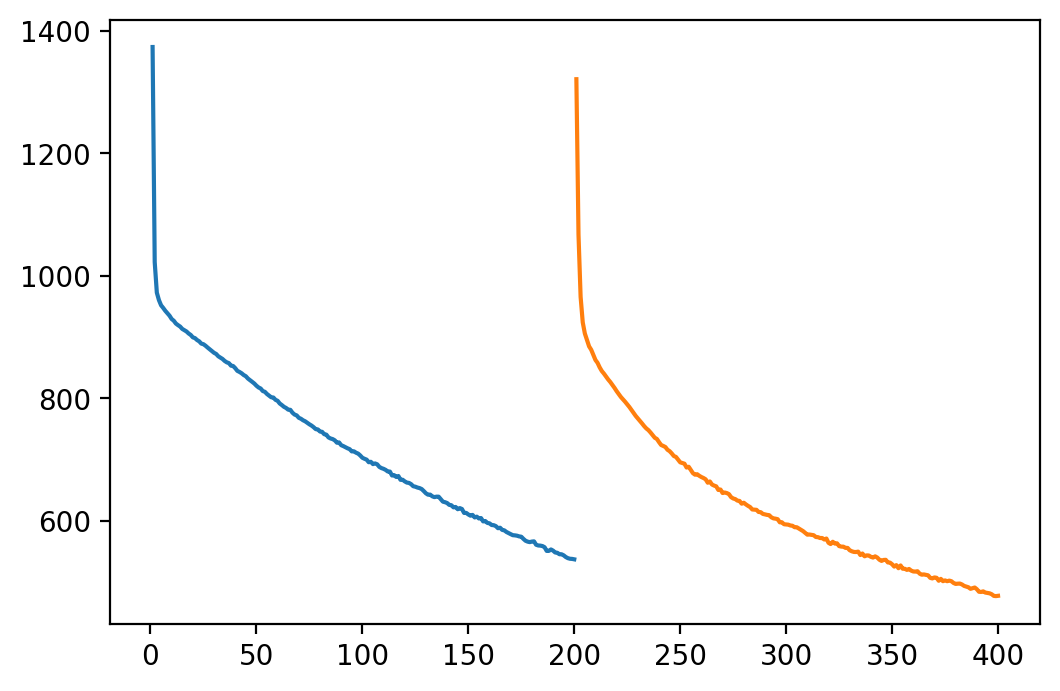

In [30]:
plt.plot(np.linspace(1,200,200), val_loss_1)
plt.plot(np.linspace(201,400,200), val_loss_2)

In [27]:
val_loss_1

array([1373.6758 , 1022.17804,  972.29224,  960.05396,  951.67896,
        947.35925,  942.6195 ,  938.73035,  934.6228 ,  929.244  ,
        926.38153,  921.81665,  919.2001 ,  916.8703 ,  913.04553,
        910.8683 ,  908.86035,  905.5964 ,  903.18835,  899.2686 ,
        898.0086 ,  894.8799 ,  892.74677,  889.0076 ,  888.0531 ,
        885.52155,  882.48157,  879.7721 ,  876.83234,  874.0073 ,
        872.1312 ,  868.35925,  866.18274,  863.95605,  860.7478 ,
        858.4439 ,  857.14703,  852.99896,  852.47705,  848.9279 ,
        844.5112 ,  842.75183,  840.6006 ,  837.7087 ,  835.71277,
        831.9187 ,  829.3239 ,  826.5803 ,  823.8258 ,  820.25793,
        817.3912 ,  815.6828 ,  811.5392 ,  810.24915,  806.64166,
        803.87256,  801.30035,  800.9269 ,  797.19556,  795.555  ,
        791.1904 ,  788.6232 ,  785.7365 ,  783.8865 ,  781.04364,
        780.8554 ,  776.1571 ,  773.1229 ,  771.74854,  767.8097 ,
        766.2474 ,  763.80255,  762.0934 ,  759.6708 ,  757.17

In [28]:
val_loss_2

array([1321.0662 , 1067.1853 ,  965.34314,  923.8026 ,  905.52185,
        894.7586 ,  884.52136,  878.97876,  870.6161 ,  862.29193,
        857.53296,  850.1432 ,  844.2327 ,  840.0049 ,  835.2877 ,
        830.43945,  826.30896,  821.4812 ,  816.6698 ,  811.35077,
        806.7124 ,  801.80676,  797.8676 ,  794.01715,  789.6621 ,
        785.48816,  780.62573,  775.81494,  770.86365,  766.813  ,
        762.9439 ,  758.5453 ,  754.17224,  750.4241 ,  747.6293 ,
        743.7612 ,  739.5639 ,  735.21344,  733.21606,  728.0485 ,
        723.3696 ,  721.81604,  720.06104,  715.5883 ,  713.2926 ,
        709.6167 ,  705.34674,  703.84644,  699.4608 ,  695.02905,
        693.94415,  692.82434,  686.59204,  687.83594,  682.45734,
        677.38104,  674.85535,  675.617  ,  673.0476 ,  671.0127 ,
        669.4001 ,  667.31537,  661.74207,  663.7545 ,  658.7896 ,
        657.0397 ,  655.7762 ,  649.8333 ,  650.66736,  644.85913,
        645.7134 ,  644.8041 ,  643.0743 ,  638.1852 ,  636.00